In [1]:
%cd ~/../../data/p_dsi/teams2023/team1/

[Errno 2] No such file or directory: '/Users/aleksandra.cvetanovska/../../data/p_dsi/teams2023/team1/'
/Users/aleksandra.cvetanovska/Desktop/Vandy/Semester II/Teams/sp23-asurion-team1/2_EDA


# Load Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose

# Load Data

In [3]:
cleaned_data = pd.read_excel('combined_phone_data.xlsx')

# Plot Claim Over Time

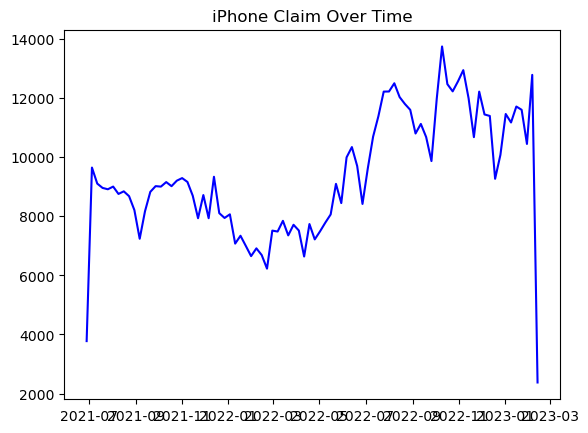

In [4]:
iphone_data = cleaned_data[cleaned_data['brand'] == 'apple'].groupby(['weeks_monday']).agg({"claim": "sum"}).reset_index()

time = np.array(iphone_data['weeks_monday'])
claims = np.array(iphone_data['claim'])

plt.plot(time, claims, color='blue')
plt.title('iPhone Claim Over Time')
plt.show()

# Helper Functions

In [5]:
def plot_decomp(dec):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
    dec.observed.plot(ax=ax1)
    ax1.set_ylabel('Observed')
    dec.trend.plot(ax=ax2)
    ax2.set_ylabel('Trend')
    dec.seasonal.plot(ax=ax3)
    ax3.set_ylabel('Seasonal')
    dec.resid.plot(ax=ax4)
    ax4.set_ylabel('Residual')
    plt.tight_layout()
    plt.show()

# Investigate Seasonalilty

## Seasonal Decomposition Using Moving Averages (Naive)

Additive Decomposition: yt = St + Tt + Rt (most appropriate if the magnitude of the seasonal fluctuations, or the variation around the trend-cycle, does not vary with the level of the time series)

Multiplicative Decomposition: yt = St * Tt * Rt (most appropriate when the variation in the seasonal pattern, or the variation around the trend-cycle, appears to be proportional to the level of the time series)

*The observed data*: This is the original time series data that you are analyzing. It represents the actual values of your data over time.

*The trend component*: This component represents the long-term progression of your data over time. It is calculated by smoothing out the observed data to remove any short-term fluctuations or noise. The trend component can help you identify the general direction and level of your data over time.

*The seasonal component*: This component represents the repeating patterns or cycles in your data that occur at fixed intervals. It is calculated by removing the trend component from the observed data. The seasonal component can help you identify regular patterns or cycles in your data over time, such as daily, weekly, monthly, or annual patterns.

*The residual component*: This component represents the random or unpredictable fluctuations in your data that are not accounted for by the trend or seasonal components. It is calculated by subtracting the sum of the trend and seasonal components from the observed data. The residual component can help you identify any unusual or unexpected changes in your data over time

### Aditive

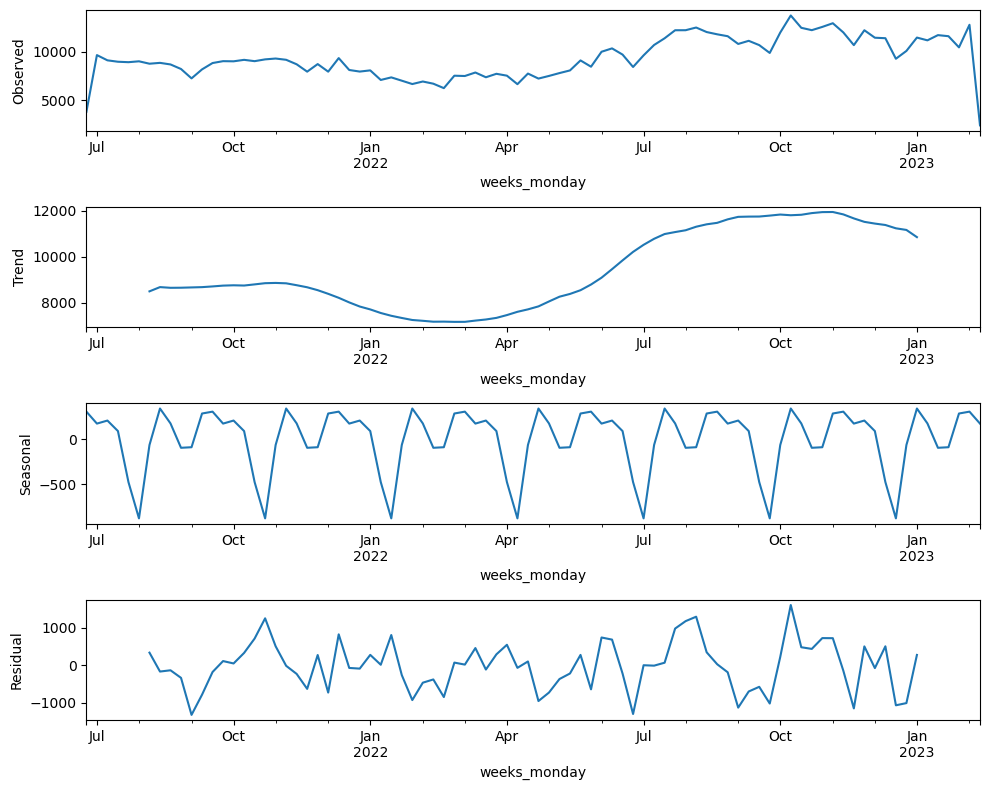

In [6]:
iphone_data = cleaned_data[cleaned_data['phone model'].str.contains('apple iphone')]
iphone_data = iphone_data.groupby(['weeks_monday']).agg({"claim": "sum"}).reset_index()
iphone_data.index = iphone_data.weeks_monday

decomposition = seasonal_decompose(iphone_data['claim'], model='additive', period=12)
plot_decomp(decomposition)

### Multiplicative

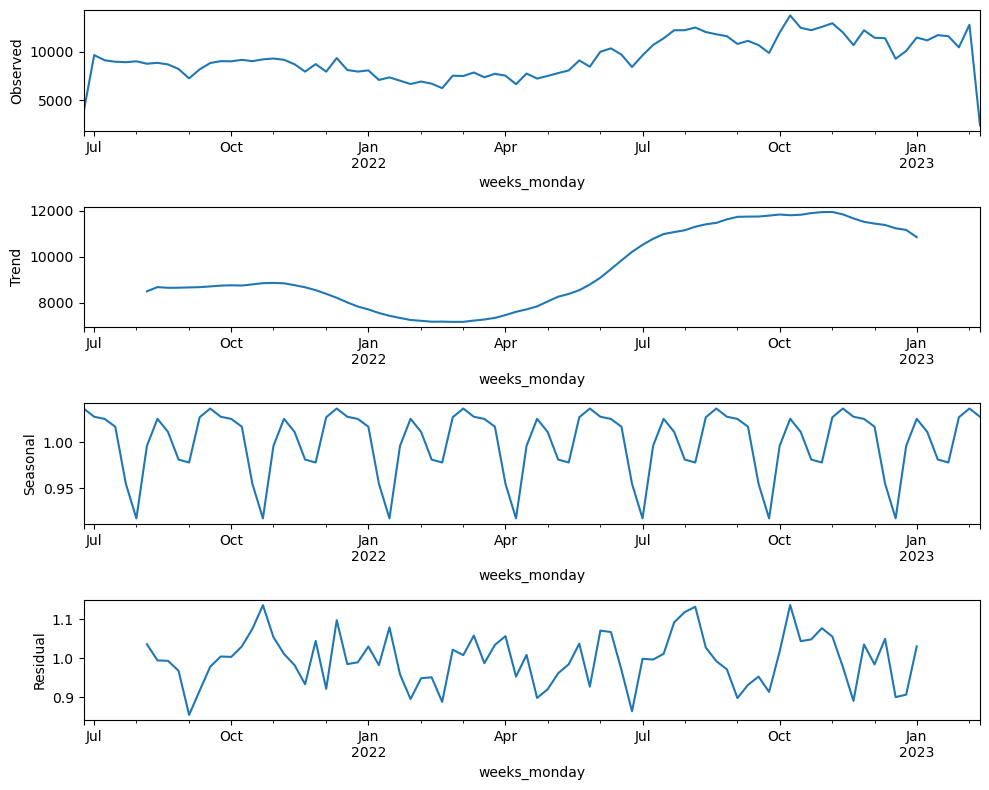

In [7]:
decomposition = seasonal_decompose(iphone_data['claim'], model='mutiplicative', period=12)
plot_decomp(decomposition)

**Note:** Since the seasonal variation does not seem to increase as we move across time, additive composition seems to fit this data better.

Google Data

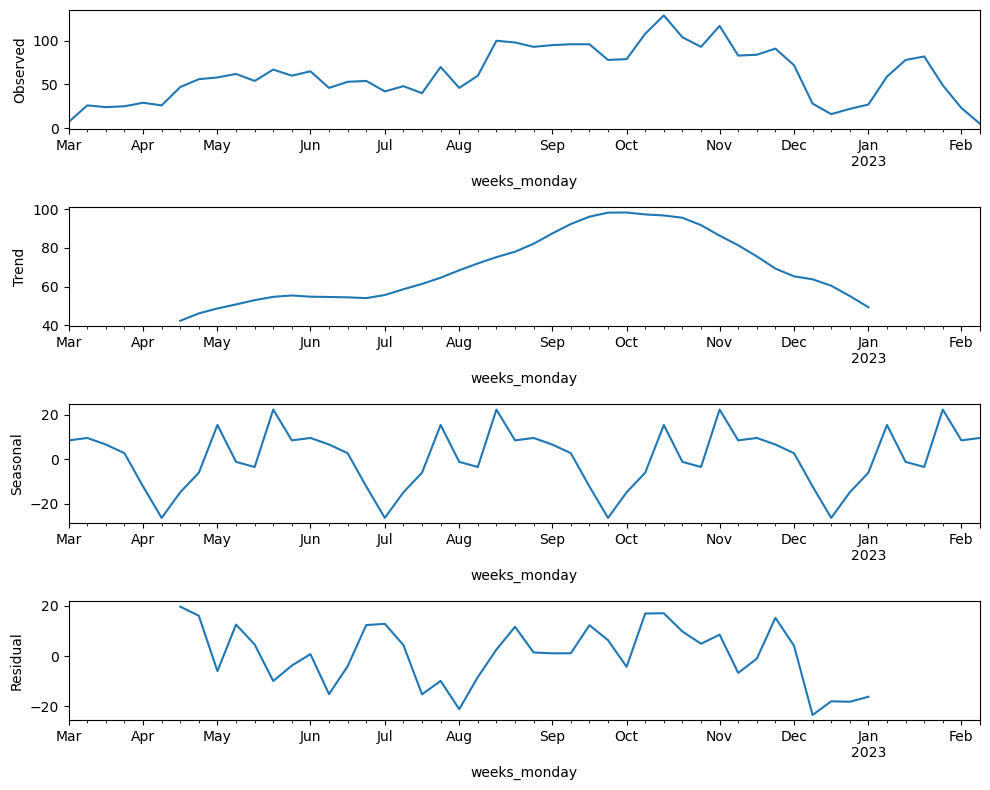

In [9]:
google_data = cleaned_data[cleaned_data['brand'] == 'google']
google_data = google_data.groupby(['weeks_monday']).agg({"claim": "sum"}).reset_index()
google_data.index = google_data.weeks_monday

decomposition = seasonal_decompose(google_data['claim'], model='additive', period=12)
plot_decomp(decomposition)

Samsung Data

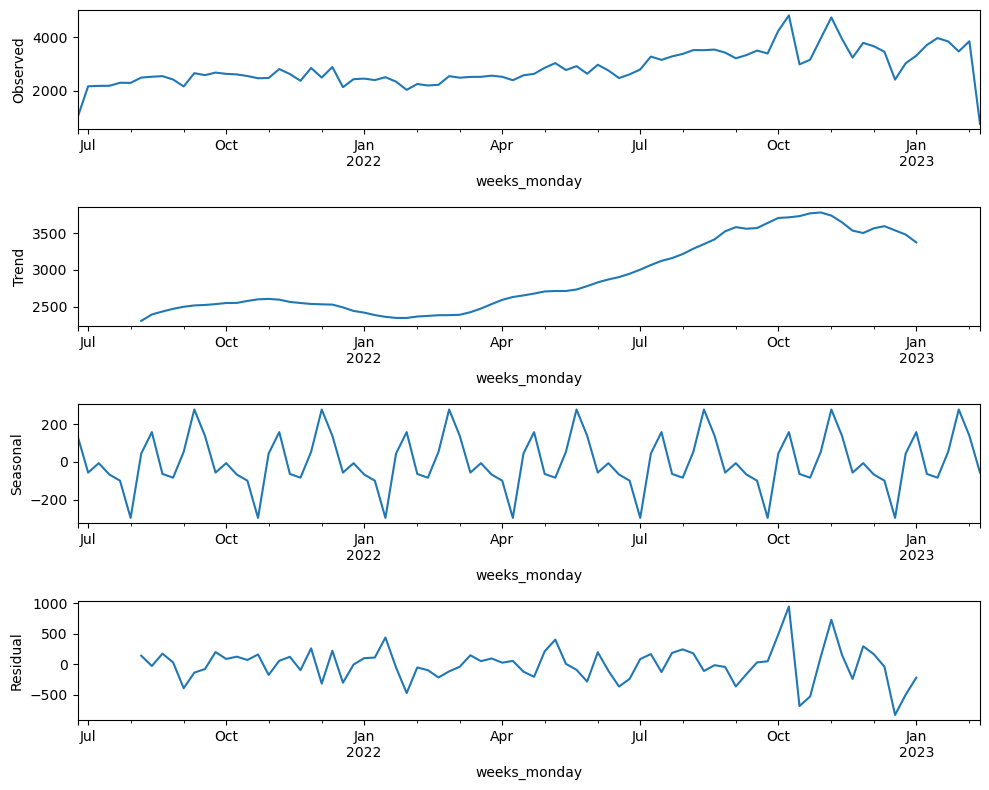

In [10]:
samsung_data = cleaned_data[cleaned_data['brand'] == 'samsung']
samsung_data = samsung_data.groupby(['weeks_monday']).agg({"claim": "sum"}).reset_index()
samsung_data.index = samsung_data.weeks_monday

decomposition = seasonal_decompose(samsung_data['claim'], model='additive', period=12)
plot_decomp(decomposition)

## Seasonal-Trend decomposition using LOESS (STL)

In [11]:
from statsmodels.tsa.seasonal import STL


/var/folders/qc/xhd08p257qs0hgklv6c67x640000gn/T/ipykernel_81779/860867246.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  res.plot().show()


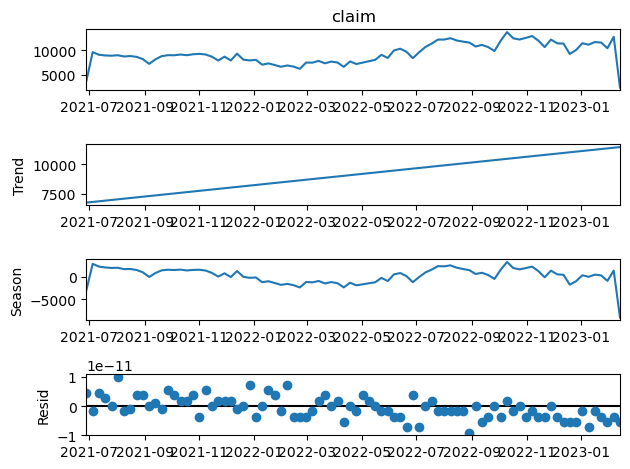

In [12]:
i_data = pd.Series(iphone_data['claim'], index=iphone_data['weeks_monday'])

res = STL(i_data, robust = False, seasonal = 9).fit() 
res.plot().show()


# Stationary Data

Convert the data to a stationary series: In order for the ARIMA model to work properly, the time series needs to be stationary. This means that the mean and variance of the series should be constant over time. You can check for stationarity by plotting the rolling mean and rolling standard deviation of the series and visually inspecting the plot. If the mean and/or variance changes over time, you can make the series stationary by differencing the series or by taking the logarithm of the series.

**Note:** We already are pretty certain that the time series is not stationary, due to the earlier plots but let's calculate the mean & variance so we can prove that mathematically.

In [13]:
X = iphone_data['claim']
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()

print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=8056.441860, mean2=10643.906977
variance1=1250912.157254, variance2=4169406.467331


In [14]:
# Differentiate to make the data stationary
df_diff = iphone_data.diff().dropna()

In [15]:
df_diff.head()

,weeks_monday,claim
weeks_monday,,
2021-07-05,7 days,5873.0
2021-07-12,7 days,-543.0
2021-07-19,7 days,-146.0
2021-07-26,7 days,-46.0
2021-08-02,7 days,91.0


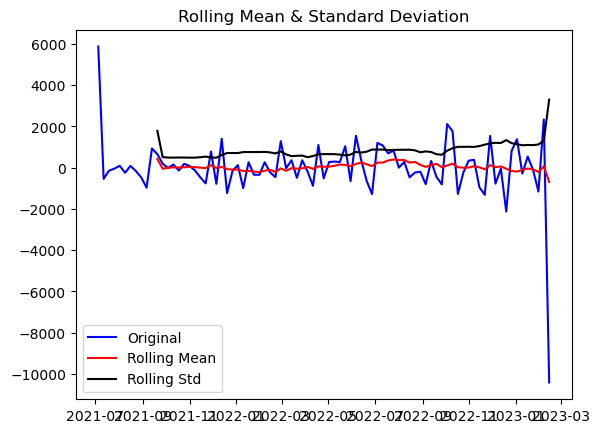

In [16]:
rolmean = df_diff['claim'].rolling(window=12).mean()
rolstd = df_diff['claim'].rolling(window=12).std()

plt.plot(df_diff['claim'], color='blue', label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend()
plt.title('Rolling Mean & Standard Deviation')
plt.show()

In [17]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_diff['claim'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical Values: {result[4]}')


ADF Statistic: -3.2091130440105626
p-value: 0.01946320336154488
Critical Values: {'1%': -3.518281134660583, '5%': -2.899878185191432, '10%': -2.5872229937594873}


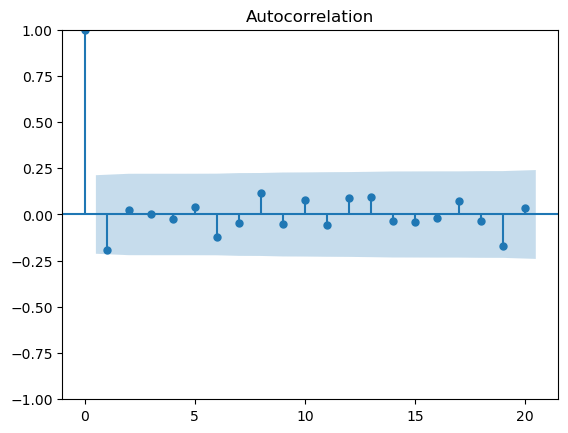

/Users/aleksandra.cvetanovska/opt/anaconda3/envs/neuralnet/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


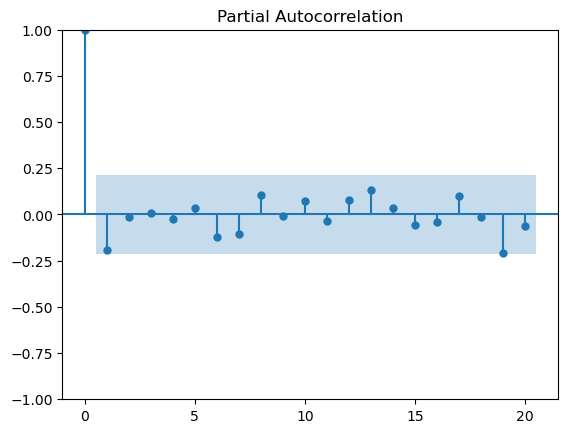

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_diff['claim'], lags=20)
plt.show()
plot_pacf(df_diff['claim'], lags=20)
plt.show()